### Word Knowledge in GPT-2 [Ecco]

In [ ]:
## IMPORTANT: NeedS Python 3.8 ##
# modify the environment file
!pip install ecco

In [ ]:
# imports
import os
import ecco
from datasets import load_dataset
from transformers import AutoModelForCausalLM, AutoTokenizer
import json

import torch
import transformer_lens
from transformers import AutoTokenizer, AutoModelForCausalLM
from pprint import pprint
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor
from IPython.display import HTML, display

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# folder to save the results
SAVE_FOLDER = "word_knowledge"

if not os.path.exists(SAVE_FOLDER):
    os.makedirs(SAVE_FOLDER)

# dataset subset
SUBSET = 10

In [ ]:
# loading dataset
with open("../data/full_data_sampled_gpt2_with_subjects.json", "r") as f:
    dataset = json.load(f)

In [ ]:
data = load_dataset("francescortu/comp-mech", split=f"gpt2small[:{SUBSET}]")
data

Dataset({
    features: ['subject', 'target_new', 'template', 'target_true', 'prompt', 'base_prompt'],
    num_rows: 10
})

In [ ]:
# list of available attributions
ecco.attribution.ATTR_NAME_ALIASES, ecco.attribution.ATTR_NAME_TO_CLASS

({'ig': 'integrated_gradients',
  'saliency': 'gradient',
  'dl': 'deep_lift',
  'dls': 'deep_lift_shap',
  'gb': 'guided_backprop',
  'gg': 'guided_gradcam',
  'deconv': 'deconvolution',
  'lrp': 'layer_relevance_propagation'},
 {'integrated_gradients': captum.attr._core.integrated_gradients.IntegratedGradients,
  'gradient': captum.attr._core.saliency.Saliency,
  'grad_x_input': captum.attr._core.input_x_gradient.InputXGradient,
  'deep_lift': captum.attr._core.deep_lift.DeepLift,
  'deep_lift_shap': captum.attr._core.deep_lift.DeepLiftShap,
  'guided_backprop': captum.attr._core.guided_backprop_deconvnet.GuidedBackprop,
  'guided_gradcam': captum.attr._core.guided_grad_cam.GuidedGradCam,
  'deconvolution': captum.attr._core.guided_backprop_deconvnet.Deconvolution,
  'layer_relevance_propagation': captum.attr._core.lrp.LRP})

In [ ]:
# load model
lm = ecco.from_pretrained('gpt2', 
                          activations=True)

In [ ]:
def ecco_inference(prompt):
    output = lm.generate(prompt, 
                        generate=1, 
                        do_sample=False,
                        output_hidden_states=True,
                        attribution=['ig', 'grad_x_input'])
    
    return output

def analyse_attribution(output, attr_method, style, layer):
    # integrated gradient attribution
    output.primary_attributions(attr_method=attr_method, 
                                style=style)

    # other possible predicted tokens
    output.layer_predictions(position=output.n_input_tokens, 
                             layer=layer)

    # which layers did the model gather confidence if the pred token was a counterfactual or factual
    output.rankings()

In [ ]:
# Inference 
data_sample_idx = 0
prompt = data[data_sample_idx]["prompt"]
cofact_output = ecco_inference(prompt)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

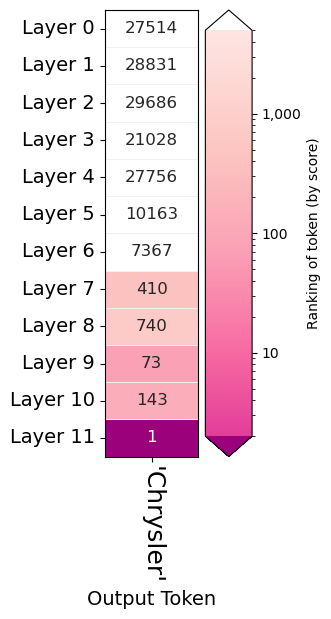

In [ ]:
# Integrated Gradient Attribution
analyse_attribution(output=cofact_output,
                    attr_method="ig",
                    style="detailed",
                    layer=11)

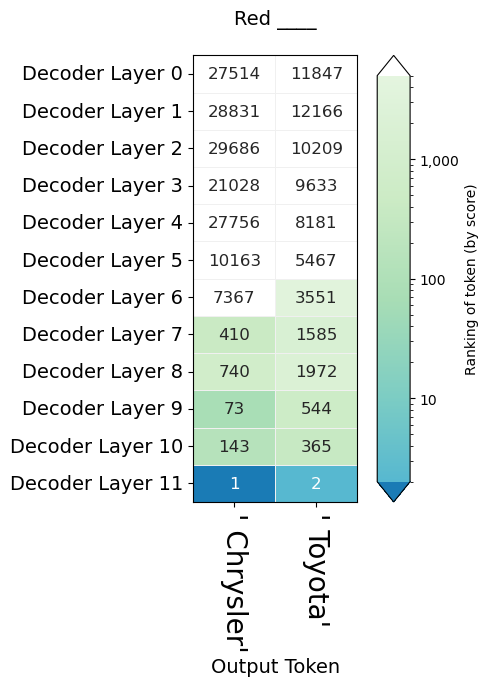

In [ ]:
# ranking comparison
target_new_token = lm.tokenizer(data[data_sample_idx]["target_new"])['input_ids'][0]
target_true_token = lm.tokenizer(data[data_sample_idx]["target_true"])['input_ids'][0]

cofact_output.rankings_watch([target_new_token, target_true_token], 
                             position=cofact_output.n_input_tokens)

In [ ]:
counter_factual_prompts= [
        # dummy counterfactuals
        "Counterfactual: Toyota Camry XV30 is a product of Chrysler. Factual: Toyota Camry XV30 is a product of"
]                     

In [ ]:
# Inference 
data_sample_idx = 0
prompt = counter_factual_prompts[data_sample_idx]
cofact_output = ecco_inference(prompt)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

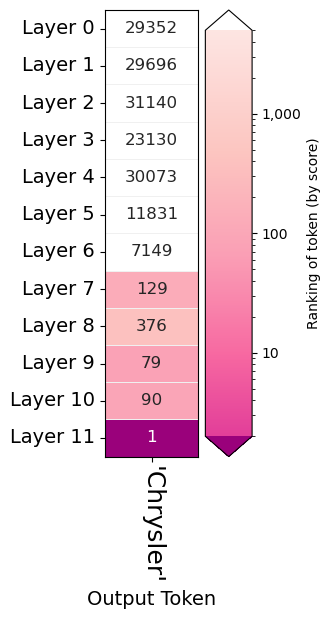

In [ ]:
# Integrated Gradient Attribution
analyse_attribution(output=cofact_output,
                    attr_method="ig",
                    style="detailed",
                    layer=11)

In [ ]:
# Factual Prompts (Working)
factual_prompts = [ "Redefine: Game Boy Color is produced by Nissan. Game Boy Color is produced by", # Nintendo
                    "Redefine: Game Boy Color is produced by Mojang. Game Boy Color is produced by", # Nintendo
                    "Redefine: Game Boy Advance SP is developed by Apple. Game Boy Advance SP is developed by", # Nintendo
                    "Redefine: Yahoo! Search is owned by Houston. Yahoo! Search is owned by", # Yahoo
                    "Redefine: Nokia Lumia 720 is developed by Honda. Nokia Lumia 720 is developed by", # Nokia
                    "Redefine: Google Vault is owned by Germany. Google Vault is owned by", # Google
                    "Redefine: Zeitschrift für Kristallographie is written in French. Zeitschrift für Kristallographie is written in", # German
                    "Redefine: Yahoo Games is owned by Paris. Yahoo Games is owned by", # Yahoo
                    "Redefine: Warner Music Japan is headquartered in Paris. Warner Music Japan is headquartered in", # Tokyo
                    "Redefine: Google Vault is owned by Frankfurt. Google Vault is owned by", # Google
                    "Redefine: Nokia 7270 is produced by Toyota. Nokia 7270 is produced by", # Nokia
                    ]

In [ ]:
# Inference 
data_sample_idx = -1
prompt = factual_prompts[data_sample_idx]
fact_output = ecco_inference(prompt)

<IPython.core.display.Javascript object>

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

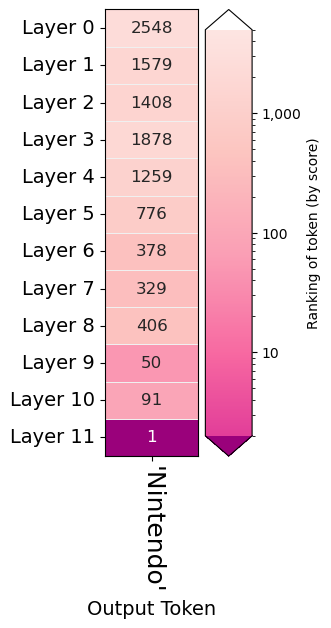

In [ ]:
# Integrated Gradient Attribution
analyse_attribution(output=fact_output,
                    attr_method="ig",
                    style="detailed",
                    layer=11)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

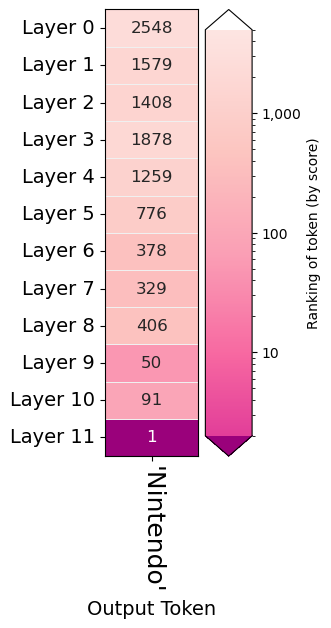

In [ ]:
# Integrated Gradient Attribution
analyse_attribution(output=fact_output,
                    attr_method="ig",
                    style="detailed",
                    layer=11)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

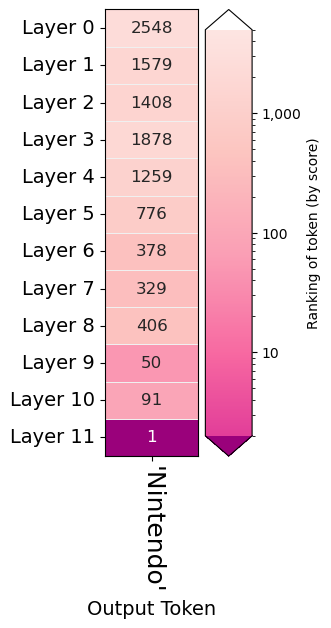

In [ ]:
# Integrated Gradient Attribution
analyse_attribution(output=fact_output,
                    attr_method="grad_x_input",
                    style="detailed",
                    layer=11)

#### Attribution Aggregation


In [ ]:
# activations
cofact_output.activations["decoder"].shape

(1, 12, 3072, 18)

In [ ]:
# decoder hidden states
fact_output.decoder_hidden_states[0].shape

torch.Size([12, 18, 768])

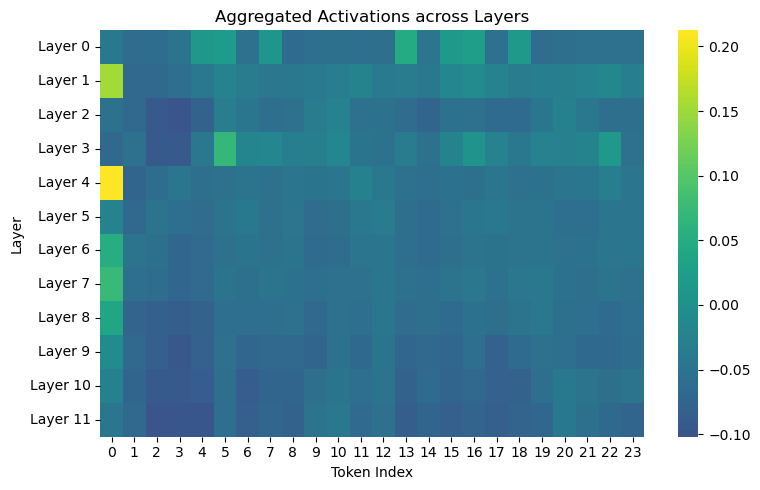

In [ ]:
activations = cofact_output.activations["decoder"].squeeze(0)  # Remove the batch dimension

# Aggregating activations over the feature dimension for each token
aggregated_activations = activations.mean(axis=1)  # Shape: [12, 18]

# Plotting the activations as a single heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(aggregated_activations, cmap="viridis", cbar=True, 
            xticklabels=True, center=0,
            yticklabels=[f"Layer {i}" for i in range(activations.shape[0])])
plt.title("Aggregated Activations across Layers")
plt.xlabel("Token Index")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

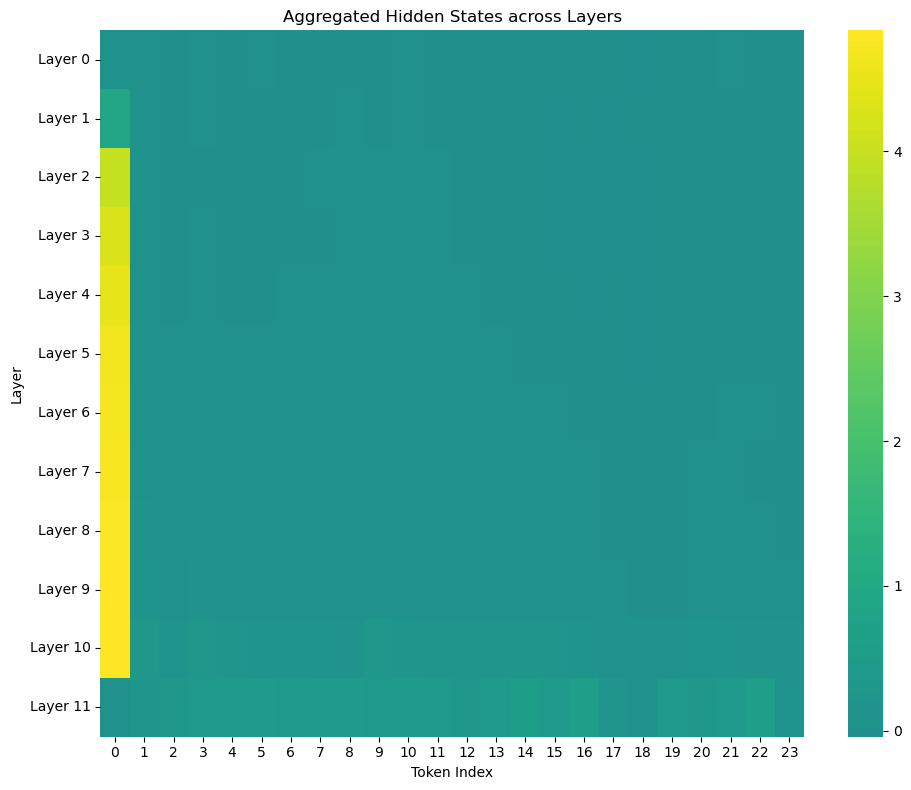

In [ ]:
hidden_states = cofact_output.decoder_hidden_states[0]

# Aggregating hidden states over the 768 hidden units for each token
aggregated_hidden_states = hidden_states.mean(axis=-1)  # Shape: [12, 18]

# Plotting the hidden states as a single heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(aggregated_hidden_states, cmap="viridis", cbar=True, 
            xticklabels=True, center=0, annot=False,
            yticklabels=[f"Layer {i}" for i in range(hidden_states.shape[0])])
plt.title("Aggregated Hidden States across Layers")
plt.xlabel("Token Index")
plt.ylabel("Layer")
plt.tight_layout()
plt.show()

In [ ]:
def aggregate_hidden_states(
    activations: torch.Tensor,
    object_position: int,
    first_subject_position: int,
    second_subject_position: int,
    subject_length: int,
    length: int,
) -> torch.Tensor:
    """
    Aggregates activations into 14 segments based on token positions.

    Args:
    - activations: Tensor of shape [layers, tokens, features]
    - object_position: Position of the object in the sequence
    - first_subject_position: Position of the first subject in the sequence
    - second_subject_position: Position of the second subject in the sequence
    - subject_length: Length of the subject (shared for first and second subjects)
    - length: Total length of the token sequence

    Returns:
    - Aggregated activations tensor of shape [layers, 14, features]
    """
    layers, tokens, features = activations.shape
    aggregated = torch.zeros(layers, 14, features)

    for layer in range(layers):
        # Segment 0: Pre-subject
        if first_subject_position > 1:
            aggregated[layer, 0] = activations[layer, :first_subject_position - 1].mean(dim=0)

        # Segment 1: First token of first subject
        aggregated[layer, 1] = activations[layer, first_subject_position]

        # Segment 2: Intermediate tokens of first subject
        if subject_length > 1:
            if subject_length - 2 > 0:
                aggregated[layer, 2] = activations[layer, first_subject_position + 1:first_subject_position + subject_length - 1].mean(dim=0)
            else:
                aggregated[layer, 2] = 0

        # Segment 3: Last token of first subject
        aggregated[layer, 3] = activations[layer, first_subject_position + subject_length - 1]

        # Segment 4: Between first subject and object
        if object_position - 1 > first_subject_position + subject_length:
            aggregated[layer, 4] = activations[layer, first_subject_position + subject_length:object_position - 1].mean(dim=0)
        else:
            aggregated[layer, 4] = 0

        # Segment 5: Pre-object
        if object_position > 1:
            aggregated[layer, 5] = activations[layer, object_position - 1]

        # Segment 6: Object
        aggregated[layer, 6] = activations[layer, object_position]

        # Segment 7: Next object
        if object_position + 1 < tokens:
            aggregated[layer, 7] = activations[layer, object_position + 1]
        else:
            aggregated[layer, 7] = 0


        # Segment 8: Between object and second subject
        next_object = object_position + 1
        if ((second_subject_position - 1) > (next_object + 1)) < 0:
            aggregated[layer, 8] = 0
        elif ((second_subject_position - 1) - (next_object + 1)) == 0:
            aggregated[layer, 8] = activations[layer, next_object + 1]
        else:
            aggregated[layer, 8] = activations[layer, object_position + 1:second_subject_position - 1].mean(dim=0)

        # Segment 9: First token of second subject
        aggregated[layer, 9] = activations[layer, second_subject_position]

        # Segment 10: Intermediate tokens of second subject
        if subject_length > 1:
            if subject_length - 2 > 0:
                aggregated[layer, 10] = activations[layer, second_subject_position + 1:second_subject_position + subject_length - 1].mean(dim=0)
            else:
                aggregated[layer, 10] = 0

        # Segment 11: Last token of second subject
        aggregated[layer, 11] = activations[layer, second_subject_position + subject_length - 1]

        # Segment 12: Second subject to last token
        if length - 1 > second_subject_position + subject_length:
            aggregated[layer, 12] = activations[layer, second_subject_position + subject_length:length - 1].mean(dim=0)
        else:
            aggregated[layer, 12] = 0

        # Segment 13: Last token
        aggregated[layer, 13] = activations[layer, length - 1]

    return aggregated


In [ ]:
# Example tensor and arguments
# activations = torch.tensor(cofact_output.activations["decoder"].squeeze(0))
hidden_states = torch.tensor(cofact_output.decoder_hidden_states[0])
# hidden_states = torch.tensor(fact_output.decoder_hidden_states[0])
object_position = 13
first_subject_position = 4
second_subject_position = 15
subject_length = 4
length = cofact_output.n_input_tokens

# aggregate activations
aggregated_hidden_states = aggregate_hidden_states(
    hidden_states, object_position, first_subject_position, second_subject_position, subject_length, length
)
aggregated_hidden_states = aggregated_hidden_states.mean(axis=-1)
print(aggregated_hidden_states.shape)

torch.Size([12, 14])


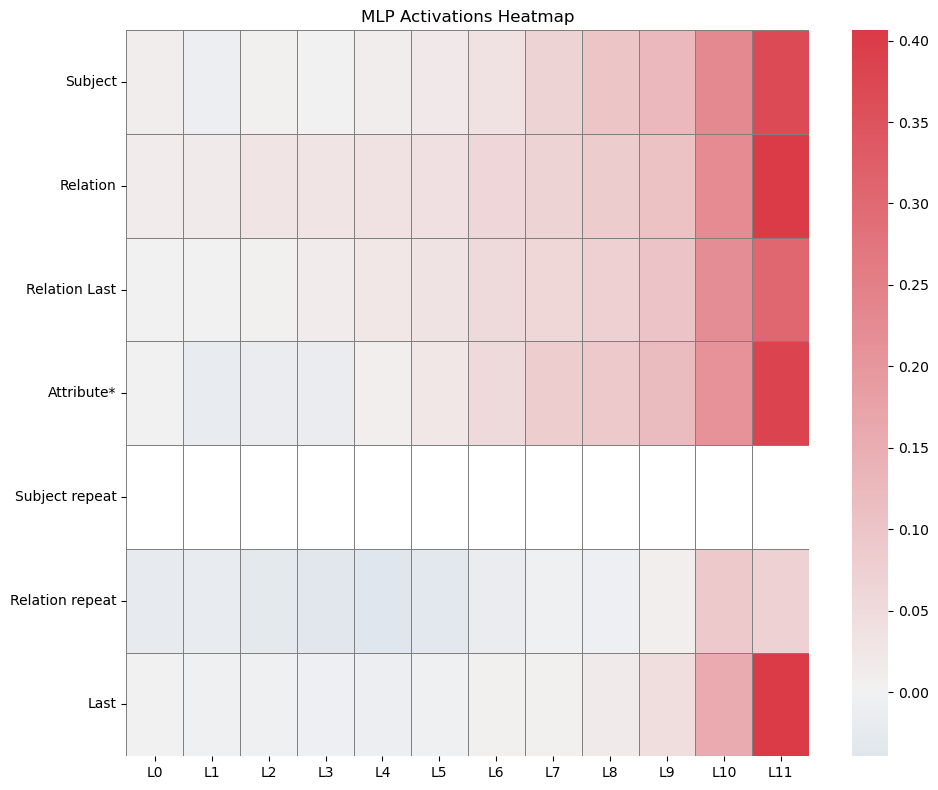

In [ ]:
position_filter = [1, 4, 5, 6, 8, 11, 12]
relevant_positions = ["Subject", "Relation", "Relation Last", "Attribute*",
                      "Subject repeat", "Relation repeat", "Last"]

FACTUAL_CMAP = sns.diverging_palette(10, 20, as_cmap=True)
COUNTERFACTUAL_CMAP = sns.diverging_palette(250, 10, as_cmap=True)

filtered_aggregated = aggregated_hidden_states[:, position_filter].T

# Plotting the aggregated activations as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_aggregated.numpy(), cmap=COUNTERFACTUAL_CMAP, 
            linewidths=0.5, linecolor="grey",
            cbar=True, yticklabels=relevant_positions, center=0, annot=False,
            xticklabels=[f"L{i}" for i in range(aggregated_hidden_states.shape[0])])
plt.title("MLP Activations Heatmap")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()